In [1]:
from scripts.filter import filtrar_dataframe
from scripts.distance import find_nearest_n_places, find_nearest_within_radius
from scripts.utilities import *
import pandas as pd
import numpy as np

## Lectura de Datos

In [2]:
llamadas = pd.read_excel('data/Llamadas 911.xlsx')

In [3]:
ruta_censo = 'data/ageb_mza_urbana_19_cpv2020/conjunto_de_datos/conjunto_de_datos_ageb_urbana_19_cpv2020.csv'
censo = pd.read_csv(ruta_censo)

In [4]:
ruta_denue = 'data/denue_19_csv/conjunto_de_datos/denue_inegi_19_.csv'
denue = pd.read_csv(ruta_denue, encoding='latin1', low_memory=False)

In [5]:
casos_mujeres = {}
for year in range(2017, 2024):
    file_path = f'data/casos_mujeres/casos_mujeres{year}.kml'
    casos_mujeres[year] = read_kml_to_dataframe(file_path)
feminicidios = pd.concat(casos_mujeres.values())


## Se encuentran las cosas mas cercanas a los feminicidios

In [6]:
R = 1.5  # Radio de 1km
distances, indices = find_nearest_within_radius(feminicidios, denue, radius=R)

In [7]:
# Agregar las cosas cercanas
feminicidios['Cosas_Cerca'] = [process_index(index_array, denue) for index_array in indices]


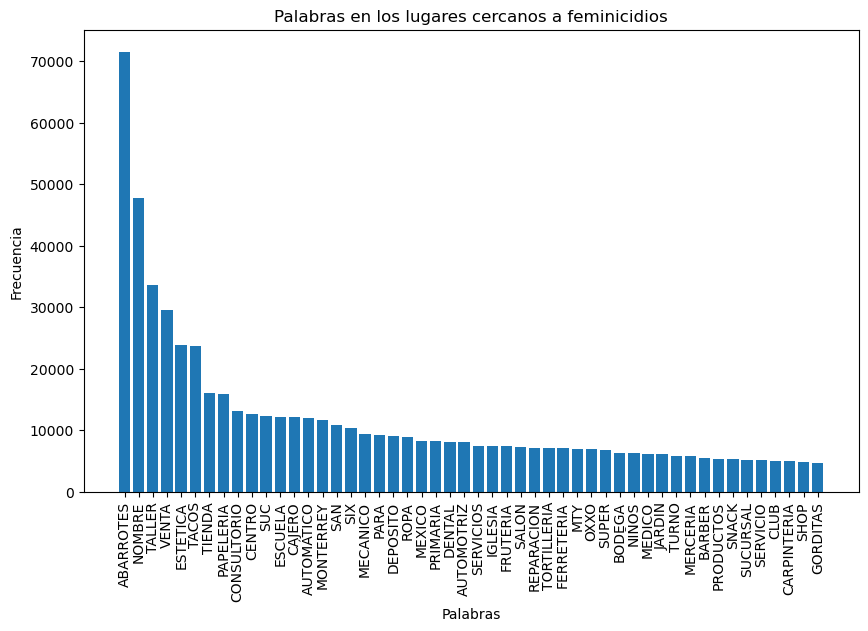

In [9]:
from collections import Counter
import matplotlib.pyplot as plt
import re
words = []
for entry in feminicidios['Cosas_Cerca']:
    # Splitear en ;
    entry_words = re.findall(r'\b\w+\b', entry)
    words.extend(entry_words)
quitar = ['DE', 'Y', 'SIN', 'LA', 'EL', 'DEL', 'LOS', 'A', 'EN', 'LAS', 'AL']
filtered_words = [word for word in words if word.upper() not in quitar]

word_counts = Counter(filtered_words)
labels, values = zip(*word_counts.items())
sorted_labels, sorted_values = zip(*sorted(zip(labels, values), key=lambda x: x[1], reverse=True))
# Palabras a quitar

plt.figure(figsize=(10, 6))
plt.bar(sorted_labels[:50], sorted_values[:50])
plt.xticks(rotation='vertical')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Palabras en los lugares cercanos a feminicidios')
plt.show()

In [14]:
import geopandas as gpd
from shapely.geometry import Point

# Filter out rows where latitude or longitude is None/NaN
feminicidios_filtered = feminicidios.dropna(subset=['latitud', 'longitud'])

# Create geometry column
geometry = [Point(xy) for xy in zip(feminicidios_filtered.longitud, feminicidios_filtered.latitud)]
geo_df = gpd.GeoDataFrame(feminicidios_filtered, geometry=geometry)

# Export to Shapefile
output_path = 'post_processed/feminicidios.shp'
geo_df.to_file(driver='ESRI Shapefile', filename=output_path)


/tmp/ipykernel_1942/3631765470.py:14: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  geo_df.to_file(driver='ESRI Shapefile', filename=output_path)
